## Explatory Analysis

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
from geopy.geocoders import Nominatim



In [2]:
# read csv file into pandas dataframe

listings = pd.read_csv('listings.csv')
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2318,Casa Madrona - Urban Oasis 1 block from the park!,2536,Megan,Central Area,Madrona,47.61082,-122.29082,Entire home/apt,296,7,32,2020-02-01,0.23,2,86
1,6606,"Fab, private seattle urban cottage!",14942,Joyce,Other neighborhoods,Wallingford,47.65411,-122.33761,Entire home/apt,90,30,150,2019-09-28,1.15,3,45
2,9419,Glorious sun room w/ memory foambed,30559,Angielena,Other neighborhoods,Georgetown,47.55017,-122.31937,Private room,62,2,148,2019-12-27,1.26,8,365
3,9460,Downtown Convention Center B&B -- Free Minibar,30832,Siena,Downtown,First Hill,47.61265,-122.32936,Private room,79,3,466,2020-03-07,3.63,4,10
4,9531,The Adorable Sweet Orange Craftsman,31481,Cassie,West Seattle,Fairmount Park,47.55539,-122.38474,Entire home/apt,165,3,40,2019-12-30,0.40,2,276


We will only need some of the columns which are 'neighbourhood', 'latitude', 'longitude'. So let's create a new dataframe with the needed columns.

In [3]:
# dataframe only with the columns neighbourhood, latitude, longitude and price
listings = listings[['neighbourhood', 'latitude', 'longitude', 'price']]
listings.head()

,neighbourhood,latitude,longitude,price
0,Madrona,47.61082,-122.29082,296
1,Wallingford,47.65411,-122.33761,90
2,Georgetown,47.55017,-122.31937,62
3,First Hill,47.61265,-122.32936,79
4,Fairmount Park,47.55539,-122.38474,165


Now let's see if there is any NaN values in out new dataframe.

In [4]:
listings.isnull().values.any()


False

It returns False, so we don't have any NaN valus in our dataframe. We can continue analyzing without dropping any values. Now we will create a new dataframe with the average prices for each neighborhood.

In [5]:
neighborhoods = pd.DataFrame(listings.groupby(['neighbourhood']).mean())
neighborhoods = neighborhoods.reset_index()
neighborhoods.columns = ['Neighborhood', 'Latitude', 'Longitude', 'Price']
neighborhoods.head()


,Neighborhood,Latitude,Longitude,Price
0,Adams,47.671661,-122.385505,150.292035
1,Alki,47.575465,-122.407382,151.793478
2,Arbor Heights,47.510568,-122.380087,117.450000
3,Atlantic,47.595194,-122.304142,217.438095
4,Belltown,47.615327,-122.345001,181.958025


__Create a map of Seattle with neighborhoods.__

We will create a city of Seattle folium map in order to see the neighborhoods on the map. Feel free to click on the markers to see the neighborhood names.

In [6]:


# Seattle latitude and longitude values
address = 'Seattle, WA'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Seattle are {}, {}.'.format(latitude, longitude))


# create map of Toronto using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)
    
map_seattle

The geograpical coordinates of Seattle are 47.6038321, -122.3300624.


### Explore neighborhoods in the city of Seattle
Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [7]:
# for more information about Foursquare API credentials please read README.md file
# get credentials from .env file
from dotenv import load_dotenv
import os

load_dotenv()
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')
VERSION = os.getenv('VERSION')

In [8]:
import requests

Let's create a function to get the top 100 venues within the 500 meter in each neighborhood.

In [9]:
LIMIT = 100


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [10]:
"""
seattle_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )
   """                               

"\nseattle_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],\n                                   latitudes=neighborhoods['Latitude'],\n                                   longitudes=neighborhoods['Longitude']\n                                  )\n   "

In [11]:
"""# save it into csv file to not repeat request, we will continue to use csv file now.

seattle_venues.to_csv('seattle_venues.csv')"""

"# save it into csv file to not repeat request, we will continue to use csv file now.\n\nseattle_venues.to_csv('seattle_venues.csv')"

In [12]:
seattle_venues = pd.read_csv('seattle_venues.csv')
seattle_venues = seattle_venues.drop(['Unnamed: 0'], axis = 1)
print(seattle_venues.shape)
seattle_venues.head()

(2087, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adams,47.671661,-122.385505,Cafe Besalu,47.671971,-122.387755,Bakery
1,Adams,47.671661,-122.385505,Tall Grass Bakery,47.671982,-122.387690,Bakery
2,Adams,47.671661,-122.385505,Kimchi House,47.671372,-122.387763,Korean Restaurant
3,Adams,47.671661,-122.385505,Gather Kitchen + Bar,47.669723,-122.384911,New American Restaurant
4,Adams,47.671661,-122.385505,Cupcake Royale and Verite Coffee,47.668829,-122.384378,Cupcake Shop


In [13]:
venue_count = seattle_venues.groupby('Neighborhood').count().reset_index()
venue_count.sort_values(['Venue'], ascending = False)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
9,Broadway,100,100,100,100,100,100
58,Pike-Market,100,100,100,100,100,100
76,University District,100,100,100,100,100,100
12,Central Business District,100,100,100,100,100,100
60,Pioneer Square,100,100,100,100,100,100
71,South Lake Union,97,97,97,97,97,97
20,First Hill,85,85,85,85,85,85
35,International District,77,77,77,77,77,77
0,Adams,75,75,75,75,75,75
79,Wallingford,67,67,67,67,67,67


In [14]:
print('There are {} uniques categories.'.format(len(seattle_venues['Venue Category'].unique())))

There are 282 uniques categories.


It seems that Broadway, Pike-Market, University District, Central Business District and Pioneer Square neighborhoods already hit the 100 venue limit. There may be more than 100 venues in these neighborhoods and we can see how many there are by increasing the limit if we like.

### Analyze each neighborhood

In [15]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_venues['Neighborhood'] 

# move neighborhood column to the first column
Neighborhood = seattle_onehot['Neighborhood']
seattle_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
seattle_onehot.insert(0, 'Neighborhood', Neighborhood)

seattle_onehot.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Print Shop,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trade School,Trail,Tram Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Adams

In [16]:
seattle_onehot.shape

(2087, 282)

__Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category.__


In [17]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped.head()

,Neighborhood,ATM,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Shop,Bistro,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Home Service,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Motel,Movie Theater,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Night Market,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Service,Pet Store,Pharmacy,Pie Shop,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Post Office,Print Shop,Pub,Radio Station,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Skate Park,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sri Lankan Restaurant,Stationery Store,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Thrift / Vintage Store,Tour Provider,Tourist Information Center,Toy / Game Store,Track,Trade School,Trail,Tram Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Waterfront,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,Adams

In [18]:
# function to sort the venues in descending order.

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

__Now let's create the new dataframe and display the top 10 venues for each neighborhood.__

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,Ice Cream Shop,Burger Joint,Thai Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Dive Bar,Dessert Shop,Italian Restaurant
1,Alki,Coffee Shop,Park,Italian Restaurant,Ice Cream Shop,Trail,Sports Bar,Fish & Chips Shop,French Restaurant,Event Space,Beach Bar
2,Arbor Heights,Spa,Yoga Studio,Fish Market,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market
3,Atlantic,Mediterranean Restaurant,Park,Seafood Restaurant,Sandwich Place,Bank,Bakery,Dry Cleaner,Residential Building (Apartment / Condo),Trail,Skate Park
4,Belltown,Bar,Pizza Place,Breakfast Spot,Bakery,Italian Restaurant,Coffee Shop,Sushi Restaurant,Gym,Dive Bar,Marijuana Dispensary


### Cluster Neighborhoods

First we will use the __elbow method__ to find the optimum __k__ value of the K-means algorithm.

In [20]:
from sklearn.cluster import KMeans  
import matplotlib.pyplot as plt

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

distortions = []
for i in range(1,11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(seattle_grouped_clustering)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()



<Figure size 640x480 with 1 Axes>

For our data, elbow method did not actually produce an elbow where the rest of the line flattened out. So we will try another method which is called __Silhouette Score__ to find the optimal __k__.

In [21]:
from sklearn.metrics import silhouette_score

# create a dictionary with k as key and silhouette score as value

k_vs_score = {}

for n_clusters in range(2,10):
    clusterer = KMeans(n_clusters=n_clusters, random_state = 10)
    preds = clusterer.fit_predict(seattle_grouped_clustering)
    centers = clusterer.cluster_centers_

    k_vs_score[n_clusters] = silhouette_score(seattle_grouped_clustering, preds, metric = 'euclidean')
    
k_vs_score

{2: 0.3816392081147356,
 3: 0.38868688924395206,
 4: 0.3695677331608486,
 5: 0.29353728130983875,
 6: 0.3691109953872242,
 7: 0.3230231899749436,
 8: 0.3589446750368159,
 9: 0.12256090435624475}

The silhouette score varies between -1 and 1 where 1 means the data instance is matched within its cluster closely. So we want the score as close to 1 as possible to select our number of clusters. Thus we will select the k value where the silhouette score is maximum.

In [22]:
# get the k number where silhouette score is maximum in range
k = max(k_vs_score, key=k_vs_score.get)

# set number of clusters
kclusters = k

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

seattle_merged = neighborhoods.iloc[:,0:3]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,47.671661,-122.385505,1.0,Ice Cream Shop,Burger Joint,Thai Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Dive Bar,Dessert Shop,Italian Restaurant
1,Alki,47.575465,-122.407382,1.0,Coffee Shop,Park,Italian Restaurant,Ice Cream Shop,Trail,Sports Bar,Fish & Chips Shop,French Restaurant,Event Space,Beach Bar
2,Arbor Heights,47.510568,-122.380087,1.0,Spa,Yoga Studio,Fish Market,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market
3,Atlantic,47.595194,-122.304142,1.0,Mediterranean Restaurant,Park,Seafood Restaurant,Sandwich Place,Bank,Bakery,Dry Cleaner,Residential Building (Apartment / Condo),Trail,Skate Park
4,Belltown,47.615327,-122.345001,1.0,Bar,Pizza Place,Breakfast Spot,Bakery,Italian Restaurant,Coffee Shop,Sushi Restaurant,Gym,Dive Bar,Marijuana Dispensary


In [24]:
# check if there is any NaN values
seattle_merged['Cluster Labels'].isnull().value_counts()


False    87
True      2
Name: Cluster Labels, dtype: int64

In [25]:
# drop NaN values
seattle_merged = seattle_merged.dropna()

__Let's visualize the resulting clusters.__

In [26]:


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



In [27]:
first_cluster = seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[0] + list(range(3, seattle_merged.shape[1]))]]
first_cluster

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,East Queen Anne,0.0,Playground,Park,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Yoga Studio
19,Fauntleroy,0.0,Park,American Restaurant,Bakery,Market,Yoga Studio,Fish Market,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
31,Highland Park,0.0,Playground,Baseball Field,Ethiopian Restaurant,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Yoga Studio
57,Olympic Hills,0.0,Playground,Bus Station,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Yoga Studio
74,South Park,0.0,Park,Playground,Brewery,Fish & Chips Shop,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Yoga Studio
75,Southeast Magnolia,0.0,Playground,Bus Stop,Baseball Field,Yoga Studio,Fish Market,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market
80,View Ridge,0.0,Park,Yoga Studio,Electronics Store,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market


In [28]:
second_cluster = seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[0] + list(range(3, seattle_merged.shape[1]))]]
second_cluster

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams,1.0,Ice Cream Shop,Burger Joint,Thai Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Dive Bar,Dessert Shop,Italian Restaurant
1,Alki,1.0,Coffee Shop,Park,Italian Restaurant,Ice Cream Shop,Trail,Sports Bar,Fish & Chips Shop,French Restaurant,Event Space,Beach Bar
2,Arbor Heights,1.0,Spa,Yoga Studio,Fish Market,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market
3,Atlantic,1.0,Mediterranean Restaurant,Park,Seafood Restaurant,Sandwich Place,Bank,Bakery,Dry Cleaner,Residential Building (Apartment / Condo),Trail,Skate Park
4,Belltown,1.0,Bar,Pizza Place,Breakfast Spot,Bakery,Italian Restaurant,Coffee Shop,Sushi Restaurant,Gym,Dive Bar,Marijuana Dispensary
5,Bitter Lake,1.0,Food Truck,Automotive Shop,ATM,Trail,Beer Bar,Thai Restaurant,Sushi Restaurant,Fast Food Restaurant,Donut Shop,Furniture / Home Store
6,Briarcliff,1.0,Bus Stop,Chinese Restaurant,Pool,Playground,Tennis Court,Video Store,Park,Ethiopian Restaurant,Event Space,Falafel Restaurant
7,Brighton,1.0,Mexican Restaurant,Vietnamese Restaurant,Bank,Gym,Food Truck,Gas Station,Taco Place,Café,Cajun / Creole Restaurant,Tex-Mex Restaurant
8,Broadview,1.0,Food Truck,Park,Convenience Store,Antique Shop,Video Store,Pizza Place,Furniture / Home Store,Thai Restaurant,Sushi Restaurant,Beer Bar
9,Broadway,1.0,Coffee Shop,Bar,Cocktail Bar,Clothing Store,American Restaurant,Mexican Restaurant,Smoke Shop,Thrift / Vintage Store,Thai Restaurant,Salon / Barbershop


In [29]:
third_cluster = seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[0] + list(range(3, seattle_merged.shape[1]))]]
third_cluster

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Rainier View,2.0,Construction & Landscaping,Yoga Studio,Fish Market,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market


Text(0.5, 0, 'cluster 0')

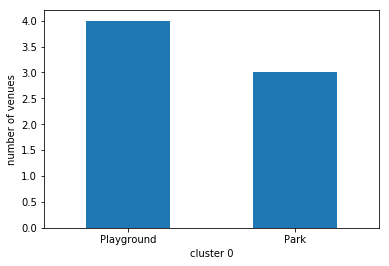

In [30]:
first_cluster['1st Most Common Venue'].value_counts().plot(kind = 'bar', rot = 0)
plt.ylabel('number of venues')
plt.xlabel('cluster 0')

Text(0.5, 0, 'cluster 1')

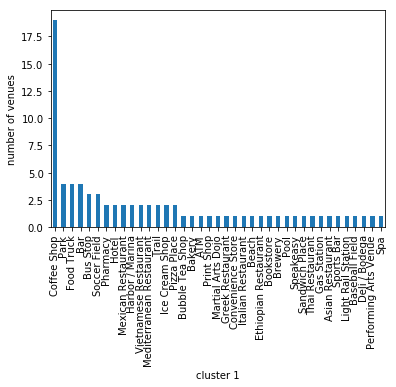

In [31]:
second_cluster['1st Most Common Venue'].value_counts().plot(kind = 'bar')
plt.ylabel('number of venues')
plt.xlabel('cluster 1')

Text(0.5, 0, 'cluster 2')

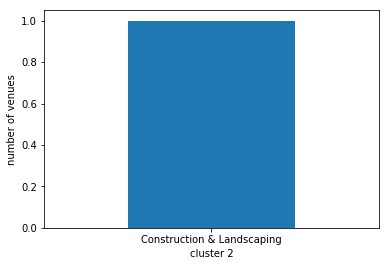

In [32]:
third_cluster['1st Most Common Venue'].value_counts().plot(kind = 'bar', rot = 0)
plt.ylabel('number of venues')
plt.xlabel('cluster 2')

Label each cluster:
- Cluster 0 : 'Outdoor Activities' 
- Cluster 1 : 'Coffee Shops'
- Cluster 2 : 'Landscaping'

In [33]:
d = {'Cluster Labels': [0.0, 1.0, 2.0],'Labels': ['Outdoor Activities', 'Coffee Shops', 'Landscaping']}
cluster_labels = pd.DataFrame(data = d)

In [34]:
seattle_merged = seattle_merged.merge(cluster_labels, on = 'Cluster Labels')
seattle_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels
0,Adams,47.671661,-122.385505,1.0,Ice Cream Shop,Burger Joint,Thai Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Dive Bar,Dessert Shop,Italian Restaurant,Coffee Shops
1,Alki,47.575465,-122.407382,1.0,Coffee Shop,Park,Italian Restaurant,Ice Cream Shop,Trail,Sports Bar,Fish & Chips Shop,French Restaurant,Event Space,Beach Bar,Coffee Shops
2,Arbor Heights,47.510568,-122.380087,1.0,Spa,Yoga Studio,Fish Market,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Coffee Shops
3,Atlantic,47.595194,-122.304142,1.0,Mediterranean Restaurant,Park,Seafood Restaurant,Sandwich Place,Bank,Bakery,Dry Cleaner,Residential Building (Apartment / Condo),Trail,Skate Park,Coffee Shops
4,Belltown,47.615327,-122.345001,1.0,Bar,Pizza Place,Breakfast Spot,Bakery,Italian Restaurant,Coffee Shop,Sushi Restaurant,Gym,Dive Bar,Marijuana Dispensary,Coffee Shops
5,Bitter Lake,47.719525,-122.351368,1.0,Food Truck,Automotive Shop,ATM,Trail,Beer Bar,Thai Restaurant,Sushi Restaurant,Fast Food Restaurant,Donut Shop,Furniture / Home Store,Coffee Shops
6,Briarcliff,47.643816,-122.405360,1.0,Bus Stop,Chinese Restaurant,Pool,Playground,Tennis Court,Video Store,Park,Ethiopian Restaurant,Event Space,Falafel Restaurant,Coffee Shops
7,Brighton,47.539836,-122.277686,1.0,Mexican Restaurant,Vietnamese Restaurant,Bank,Gym,Food Truck,Gas Station,Taco Place,Café,Cajun / Creole Restaurant,Tex-Mex Restaurant,Coffee Shops
8,Broadview,47.717367,-122.359831,1.0,Food Truck,Park,Convenience Store,Antique Shop,Video Store,Pizza Place,Furniture / Home Store,Thai Restaurant,Sushi Restaurant,Beer Bar,Coffee Shops
9,Broadway,47.620636,-122.320514,1.0,Coffee Shop,Bar,Cocktail Bar,Clothing Store,American Restaurant,Mexican Restaurant,Smoke Shop,Thrift / Vintage Store,Thai Restaurant,Salon / Barbershop,Coffee Shops


In [35]:
sv_data = pd.DataFrame(columns = ['Neighborhood', 'Top_3_Venues'])

for hood in seattle_venues['Neighborhood'].unique():
    temp = seattle_venues[seattle_venues['Neighborhood']== hood]
    series = temp['Venue Category'].value_counts()[0:3]
    string = ''
    
    for item, i in zip(series,range(len(series))):
        string = string+str(item)+' '+series.keys()[i]
        if i < len(series)-1:
            string = string + ', '
    new_row = {'Neighborhood': hood, 'Top_3_Venues': string}
    sv_data = sv_data.append(new_row, ignore_index=True)
    
sv_data

,Neighborhood,Top_3_Venues
0,Adams,"4 Burger Joint, 4 Ice Cream Shop, 3 Bakery"
1,Alki,"3 Park, 3 Coffee Shop, 2 Italian Restaurant"
2,Arbor Heights,1 Spa
3,Atlantic,"1 African Restaurant, 1 Trail, 1 Sandwich Place"
4,Belltown,"5 Pizza Place, 5 Bar, 3 Italian Restaurant"
5,Bitter Lake,"2 Food Truck, 2 Automotive Shop, 1 Beer Bar"
6,Briarcliff,"2 Bus Stop, 1 Video Store, 1 Chinese Restaurant"
7,Brighton,"2 Mexican Restaurant, 2 Vietnamese Restaurant,..."
8,Broadview,"1 Video Store, 1 Furniture / Home Store, 1 Sus..."
9,Broadway,"7 Coffee Shop, 6 Bar, 4 Cocktail Bar"


In [36]:
seattle_merged = seattle_merged.merge(sv_data, on = 'Neighborhood')
seattle_merged

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels,Top_3_Venues
0,Adams,47.671661,-122.385505,1.0,Ice Cream Shop,Burger Joint,Thai Restaurant,Bakery,Coffee Shop,Sushi Restaurant,Mexican Restaurant,Dive Bar,Dessert Shop,Italian Restaurant,Coffee Shops,"4 Burger Joint, 4 Ice Cream Shop, 3 Bakery"
1,Alki,47.575465,-122.407382,1.0,Coffee Shop,Park,Italian Restaurant,Ice Cream Shop,Trail,Sports Bar,Fish & Chips Shop,French Restaurant,Event Space,Beach Bar,Coffee Shops,"3 Park, 3 Coffee Shop, 2 Italian Restaurant"
2,Arbor Heights,47.510568,-122.380087,1.0,Spa,Yoga Studio,Fish Market,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Coffee Shops,1 Spa
3,Atlantic,47.595194,-122.304142,1.0,Mediterranean Restaurant,Park,Seafood Restaurant,Sandwich Place,Bank,Bakery,Dry Cleaner,Residential Building (Apartment / Condo),Trail,Skate Park,Coffee Shops,"1 African Restaurant, 1 Trail, 1 Sandwich Place"
4,Belltown,47.615327,-122.345001,1.0,Bar,Pizza Place,Breakfast Spot,Bakery,Italian Restaurant,Coffee Shop,Sushi Restaurant,Gym,Dive Bar,Marijuana Dispensary,Coffee Shops,"5 Pizza Place, 5 Bar, 3 Italian Restaurant"
5,Bitter Lake,47.719525,-122.351368,1.0,Food Truck,Automotive Shop,ATM,Trail,Beer Bar,Thai Restaurant,Sushi Restaurant,Fast Food Restaurant,Donut Shop,Furniture / Home Store,Coffee Shops,"2 Food Truck, 2 Automotive Shop, 1 Beer Bar"
6,Briarcliff,47.643816,-122.405360,1.0,Bus Stop,Chinese Restaurant,Pool,Playground,Tennis Court,Video Store,Park,Ethiopian Restaurant,Event Space,Falafel Restaurant,Coffee Shops,"2 Bus Stop, 1 Video Store, 1 Chinese Restaurant"
7,Brighton,47.539836,-122.277686,1.0,Mexican Restaurant,Vietnamese Restaurant,Bank,Gym,Food Truck,Gas Station,Taco Place,Café,Cajun / Creole Restaurant,Tex-Mex Restaurant,Coffee Shops,"2 Mexican Restaurant, 2 Vietnamese Restaurant,..."
8,Broadview,47.717367,-122.359831,1.0,Food Truck,Park,Convenience Store,Antique Shop,Video Store,Pizza Place,Furniture / Home Store,Thai Restaurant,Sushi Restaurant,Beer Bar,Coffee Shops,"1 Video Store, 1 Furniture / Home Store, 1 Sus..."
9,Broadway,47.620636,-122.320514,1.0,Coffee Shop,Bar,Cocktail Bar,Clothing Store,American Restaurant,Mexican Restaurant,Smoke Shop,Thrift / Vintage Store,Thai Restaurant,Salon / Barbershop,Coffee Shops,"7 Coffee Shop, 6 Bar, 4 Cocktail Bar"


In [37]:
import json
with open('seattle.json') as f:
    geo_json = json.load(f)
    
features= []    
for item in geo_json['features']:
    if item['properties']['city']=='Seattle':
        features.append(item)


In [38]:

folium.Choropleth(
    geo_data = {"type":"FeatureCollection","features":features},
    name = 'choropleth',
    data = neighborhoods,
    columns = ['Neighborhood','Price'],
    key_on = 'feature.properties.name',
    fill_color = 'YlGn',
    fill_opacity = 0.7,
    line_opacity = 0.2).add_to(map_clusters)

folium.LayerControl().add_to(map_clusters)
map_clusters